<img src='https://weclouddata.com/wp-content/uploads/2016/11/logo.png' width='30%'>
-------------

<h3 align='center'> Applied Machine Learning Course - Assignment Week 4 </h3>
<h1 align='center'> San Francisco Crime Classification
 </h1>

<br>
<center align="left"> Developed by:</center>
<center align="left"> WeCloudData Academy </center>


# Background
From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

In this assignment, we will use the SF crime dataset to perform crime category classification.

More information can be found https://www.kaggle.com/c/sf-crime.

The original training dataset `train.csv` contains 878K examples, which is a considerably large dataset. Therefore, we provide a much smaller dataset `train_2015.csv` which contains data samples from year 2015 only.

You are only required to complete this assignment using the smaller dataset `train_2015.csv`.

# Data Description


- **Dates** - timestamp of the crime incident
- **Category** - category of the crime incident. *This is the target variable you are going to predict.*
- **Descript** - detailed description of the crime incident (only in train.csv)
- **DayOfWeek** - the day of the week
- **PdDistrict** - name of the Police Department District
- **Resolution** - how the crime incident was resolved (only in train.csv)
- **Address** - the approximate street address of the crime incident 
- **X** - Longitude
- **Y** - Latitude

# Feature Union

In this assignment, you will find yourself in a situation where you use different transformers to perform feature extraction on different fields, for instance:

1. You will use `DictVectorizer` to transform non-text features.
2. You will use `TfIdfVectorizer` to transform text features.

Then you need to find out a way to combine those features. Effectively, what you need is to `hstack` (horizontally stack) the matrices resulting from different transformers into one single matrix.


Here we provide an example:

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack

data = [
    {'text': 'this is an example', 'x': 2.0},
    {'text': 'this is another example', 'x': 3.0}
]
   
other_data = [] # the list of non-text features from data
text_data = [] # the list of text features from data
for d in data:
    text_data.append(d['text'])
    
    other_d = {k : v for (k, v) in d.items() if k != 'text'}
    other_data.append(other_d)

text_vectorizer = TfidfVectorizer()
X1 = text_vectorizer.fit_transform(text_data) # the first matrix resulting from transforming the text data

other_vectorizer = DictVectorizer()
X2 = other_vectorizer.fit_transform(other_data) # the second matrix resulting from transforming the text data

print(f'X1 shape: {X1.shape}')
print(f'X2 shape: {X2.shape}')

# We now horizontally stack X1 (with 5 columns) and X2 (with 1 column) into one matrix (with 5+1=6 columns)
X = hstack([X1, X2]) # this is the matrix we will pass to a model
print(f'X shape: {X.shape}')

X1 shape: (2, 5)
X2 shape: (2, 1)
X shape: (2, 6)


# Requirements:

1. You need to complete this assignment using structured Python code, i.e., **not using Jupyter notebook**. We walked through using PyCharm to code Python scripts. Please refer to our lab scripts to understand the best practice in terms of how to properly structure you code, and avoid things like hard coding and duplicating code in multiple places.

2. You need to build a crime category classifier using the provided dataset. Split the entire dataset into 80% training and 20% test. Report the classification performance on the test set.

3. You can use any of the classifier models we learned in class so far, or try multiple ones. Use sklearn's models to train and evaluate your model.

4. Use your common sense and the knowledge we learn in the class to perform appropriate feature engineering on the features, for example:
   - Convert dates into year, month, and hour.
   - Perform text feature engineering on the `Descript` feature.
   - If you don't know how to feature engineer some particular features, e.g., `Address`, it is ok to skip those features into your model. In reality, when given datasets, there are always data fields which are not relevant to your problem or too hard to deal with, and you can choose to ignore them.
4. (Optional) 

## EDA

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

### 1. Import Data and pares dates

In [114]:
df = pd.read_csv('train_2015.csv', parse_dates=['Dates'])
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27584 entries, 0 to 27583
Data columns (total 9 columns):
Dates         27584 non-null datetime64[ns]
Category      27584 non-null object
Descript      27584 non-null object
DayOfWeek     27584 non-null object
PdDistrict    27584 non-null object
Resolution    27584 non-null object
Address       27584 non-null object
X             27584 non-null float64
Y             27584 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 1.9+ MB


### 2. Check labels

In [16]:
df['Category'].value_counts()

LARCENY/THEFT                  7511
OTHER OFFENSES                 3626
NON-CRIMINAL                   3409
ASSAULT                        2325
VEHICLE THEFT                  1408
VANDALISM                      1307
WARRANTS                       1189
BURGLARY                       1090
SUSPICIOUS OCC                  956
MISSING PERSON                  799
DRUG/NARCOTIC                   751
ROBBERY                         722
FRAUD                           549
SECONDARY CODES                 402
WEAPON LAWS                     314
TRESPASS                        213
STOLEN PROPERTY                 161
SEX OFFENSES FORCIBLE           159
FORGERY/COUNTERFEITING          127
DRUNKENNESS                     109
KIDNAPPING                       73
DISORDERLY CONDUCT               71
ARSON                            69
DRIVING UNDER THE INFLUENCE      60
PROSTITUTION                     46
LIQUOR LAWS                      35
RUNAWAY                          26
EMBEZZLEMENT                

#### Encode labels

In [115]:
encoder = LabelEncoder()
df['Category'] = encoder.fit_transform(df['Category'])
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,35,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,21,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,21,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,16,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [120]:
df['Category'].unique().shape

(37,)

### 3. Investigate Nan values

In [106]:
df.columns[df.isnull().any()]

Index([], dtype='object')

### 4. DayOfWeek

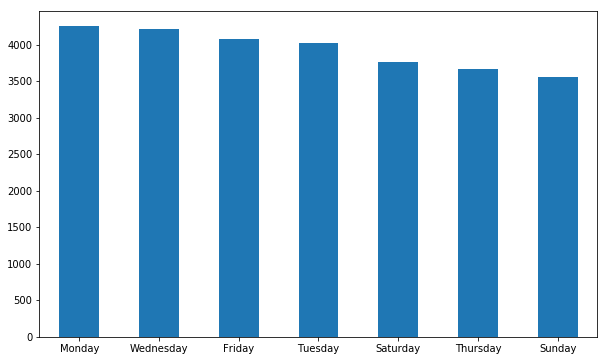

In [26]:
df['DayOfWeek'].value_counts().plot(kind='bar', rot=0, figsize=(10,6))

### 5. PdDistrict

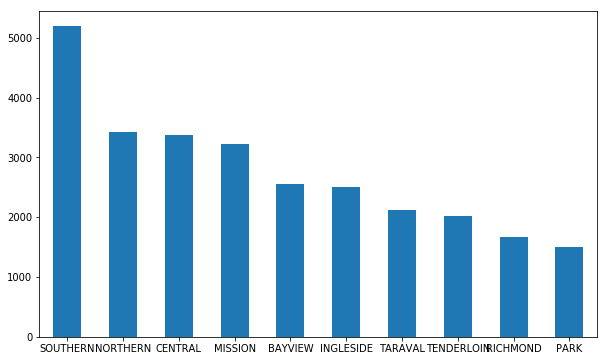

In [27]:
df['PdDistrict'].value_counts().plot(kind='bar', rot=0, figsize=(10,6))

### 6. Resolution

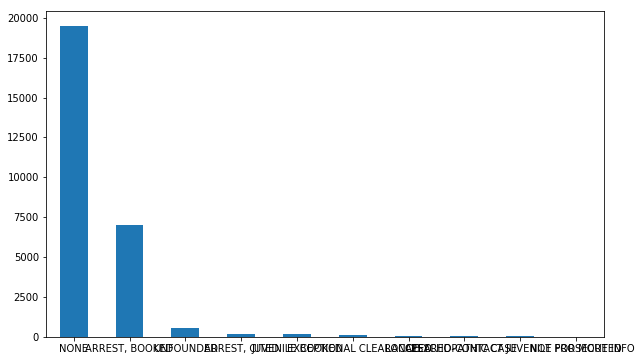

In [28]:
df['Resolution'].value_counts().plot(kind='bar', rot=0, figsize=(10,6))

### 7. Address to area

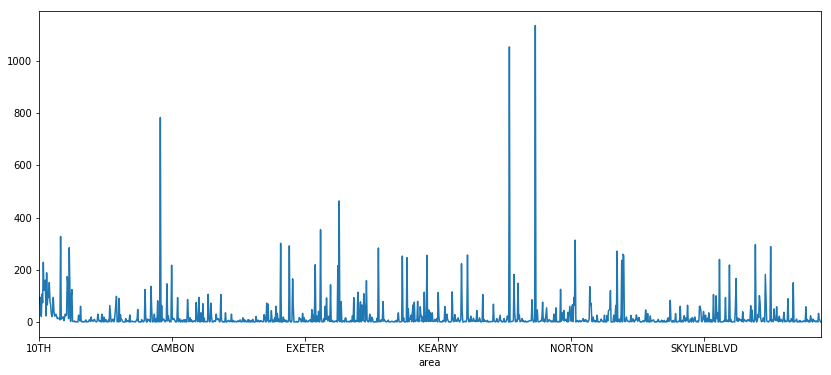

In [46]:
dff = df.copy()
dff['area'] = df['Address'].map(lambda x: x.split(' ')[-2])
dff.groupby('area').count()['Address'].plot(figsize=(14, 6))

### 8. X and Y

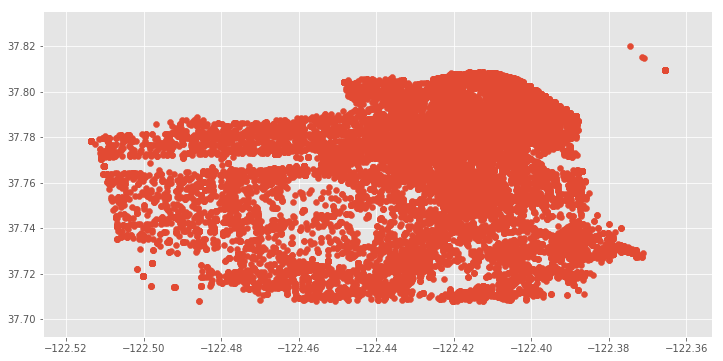

In [54]:
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'])

#### Flag for outliers

In [71]:
df['XY_outlier'] = ((df['X'] > -122.38) & (df['Y'] > 37.80)).astype(int)
df['X'] = df.apply(lambda row: np.nan if row['XY_outlier']==1 else row['X'], axis=1)
df['Y'] = df.apply(lambda row: np.nan if row['XY_outlier']==1 else row['Y'], axis=1)
df.loc[df[df['XY_outlier']==1].index].head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,date,hour,XY_outlier
1123,2015-05-03 23:18:00,SUSPICIOUS OCC,SUSPICIOUS ACT TOWARDS FEMALE,Sunday,SOUTHERN,NONE,200 Block of INTERSTATE80 HY,NaN,NaN,2015,5,3,23,1
1275,2015-05-03 16:15:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,SOUTHERN,NONE,200 Block of INTERSTATE80 HY,NaN,NaN,2015,5,3,16,1
1280,2015-05-03 16:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,SOUTHERN,NONE,200 Block of INTERSTATE80 HY,NaN,NaN,2015,5,3,16,1
1323,2015-05-03 13:15:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Sunday,SOUTHERN,NONE,200 Block of INTERSTATE80 HY,NaN,NaN,2015,5,3,13,1
1651,2015-05-02 17:00:00,OTHER OFFENSES,LOST/STOLEN LICENSE PLATE,Saturday,SOUTHERN,NONE,200 Block of INTERSTATE80 HY,NaN,NaN,2015,5,2,17,1


## Feature Extraction

In [95]:
df['year'] = df['Dates'].map(lambda x: x.year).astype(str)
df['month'] = df['Dates'].map(lambda x: x.month).astype(str)
df['date'] = df['Dates'].map(lambda x: x.day).astype(str)
df['hour'] = df['Dates'].map(lambda x: x.hour).astype(str)

df_text = df['Descript']
df_notext = df.drop(['Dates', 'Category', 'Descript', 'Address'], axis=1)
df = pd.merge(df_text, pd.get_dummies(df_notext, drop_first=True), left_index=True, right_index=True)

df.head()

,Descript,X,Y,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,"Resolution_ARREST, CITED",Resolution_CLEARED-CONTACT JUVENILE FOR MORE INFO,Resolution_EXCEPTIONAL CLEARANCE,Resolution_JUVENILE BOOKED,Resolution_LOCATED,Resolution_NONE,Resolution_NOT PROSECUTED,Resolution_PSYCHOPATHIC CASE,Resolution_UNFOUNDED,month_2,month_3,month_4,month_5,date_10,date_11,date_12,date_13,date_14,date_15,date_16,date_17,date_18,date_19,date_2,date_20,date_21,date_22,date_23,date_24,date_25,date_27,date_28,date_29,date_3,date_30,date_31,date_4,date_5,date_6,date_7,date_8,date_9,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,WARRANT ARREST,-122.425892,37.774599,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,TRAFFIC VIOLATION ARREST,-122.425892,37.774599,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,TRAFFIC VIOLATION ARREST,-122.424363,37.800414,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,GRAND THEFT FROM LOCKED AUTO,-122.426995,37.800873,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,GRAND THEFT FROM LOCKED AUTO,-122.438738,37.771541,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
